University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2022  
Luigi Acerbi  
Based on notebook by Antti Honkela  

# Lecture 5: Density estimation and cross validation

Background reading: please see Chapter 5 of the "Course notes" available in Moodle.

### 1. Simple 1D density estimation

In this exercise, we perform simple density estimation for samples from a one-dimensional density.

1. Generate 1000 samples from the standard (zero mean, unit variance) normal distribution $\mathcal{N}(0,1)$.
2. Plot the density and a normalized histogram of the samples (*Hint*: Use the option `density=True`).
3. Estimate the density using the Gaussian kernel with bandwidth values $h=0.03, 0.1, 0.3, 1$.
4. Plot the estimated densities in the same plot as the true density and the histogram. Which value seems the best?
5. Try to further improve the estimate by changing $h$. How good can you make it?

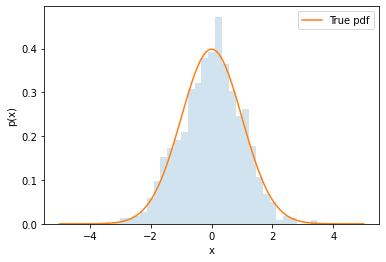

In [1]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

#1
x = npr.randn(1000)

#2
def K_gauss(x):
    """Compute Gaussian density (also kernel)."""
    return 1/np.sqrt(2*np.pi)*np.exp(-0.5*x**2)

t = np.linspace(-5, 5, 100)
plt.hist(x, 30, density=True, alpha = 0.2)
plt.plot(t, K_gauss(t), label='True pdf')
plt.xlabel('x')
plt.ylabel('p(x)')
_ = plt.legend(loc='upper right')

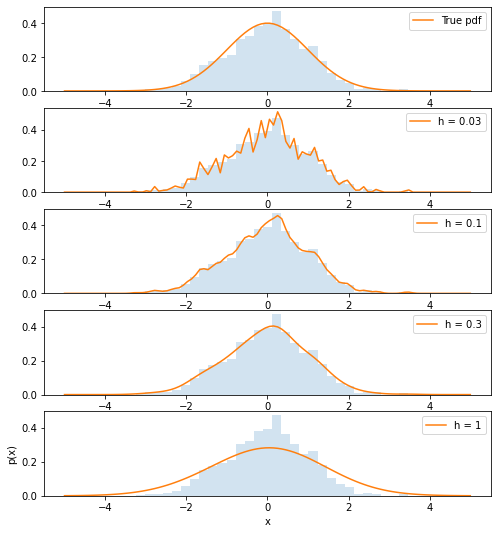

In [2]:
def kernel_density(t, x, h):
    """Compute kernel density estimate with Gaussian kernel."""
    y = np.zeros(len(t))
    for i in range(len(t)):
        y[i] = np.mean(K_gauss((t[i] - x)/ h)) / h
    return y

# 3
h_list = [0.03, 0.1, 0.3, 1]

plt.figure(figsize=(8, 9))

# plotting the true pdf again for comparison
plt.subplot(len(h_list)+1,1,1)
plt.hist(x, 30, density=True, alpha = 0.2)
plt.plot(t, K_gauss(t), label='True pdf')
_ = plt.legend(loc='upper right')

# 4
for count, h in enumerate(h_list):
    plt.subplot(len(h_list)+1,1,count+2)
    plt.hist(x, 30, density=True, alpha = 0.2)
    y = kernel_density(t, x, h)
    plt.plot(t, y, label='h = ' + str(h))
    _ = plt.legend(loc='upper right')

plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()

### 2. Cross-validation to define the bandwidth $h$

As we saw, the obvious drawback of the previous method is that the result is sensitive to the bandwidth $h$. A number of more or less heuristic methods for tuning the bandwidth have been developed. Here we will use a principled method based on leave-one-out cross-validation (LOO-CV). LOO-CV is based on the idea that we leave one point out when developing the model (here: defining the kernel density estimate) and test the model on the left-out point (here: evaluating the predictive probability of the left out point). This is repeated so that each point is left out in turn and the result is averaged over all.

Formally: let's denote by $f_{\setminus i,h}(x)$ the probability density fitted to $X \setminus \{ x_i \}$. The LOO objective to maximize is
$$ \text{LOO}(h) = \sum_{i=1}^n \log f_{\setminus i, h}(x_i).$$

1. Apply cross-validation to find the optimal bandwidth in the previous exercise
2. Plot the estimated density together with the true density and the normalized sample histogram.

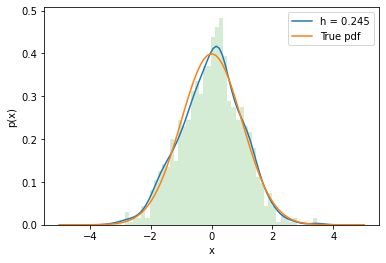

In [3]:
def loocv_kernel_density(x, hs):
    """Kernel density estimation via leave-one-out cross-validation."""
    logls = np.zeros(len(hs))
    for j in range(len(x)):
        train_x = np.delete(x, j) # Remove the j-th point
        test_x = np.array([x[j]]) # Single test point
        for i in range(len(hs)):
            logls[i] += np.log(kernel_density(test_x, train_x, hs[i]))
    return logls

hs = np.linspace(0.1, 1.0, 100)     # array of bandwidhts to try
logls = loocv_kernel_density(x, hs) # compute LOO log-likelihood
best_h = hs[np.argmax(logls)]       # take best bandwidth (with the highest LOO log-likelihood)

# Compute kernel density estimate with the best bandwidth (according to LOO)
y = kernel_density(t, x, best_h)
plt.plot(t, y, label='h = {0:.3f}'.format(best_h))
y_gauss = K_gauss(t)
plt.plot(t, y_gauss, label='True pdf')
plt.hist(x, 50, density=True, alpha = 0.2)
plt.xlabel('x')
plt.ylabel('p(x)')
_ = plt.legend(loc='upper right')

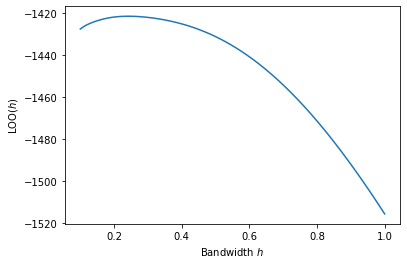

In [4]:
# Plot LOO-CV log-likelihood curve
plt.plot(hs, logls)
plt.xlabel('Bandwidth $h$')
plt.ylabel('LOO($h$)')
plt.show()

### 3. More density estimation

1. Generate a few data sets with different numbers of samples: 20, 150, 500 with the same normal distribution as above and apply the same procedure for kernel density estimation using the optimal LOO bandwidth. Does the optimal bandwidth change and if so, how?
2. Generate data from different distributions (at least uniform and Laplace) and apply the same procedure. What do you observe?
3. Generate data from the $d$-dimensional multivariate normal distribution with zero mean and unit covariance and $d = 3, 10, 20$. Estimate the density using the above procedure. Evaluate it at the points $(0, \dots, 0)$ and $(1, \dots, 1)$ and compare with the ground truth. What do you observe?

*Hint*: In the $d$-variate case, use the multivariate normal $\mathcal{N}(0, I_d)$ as the kernel.

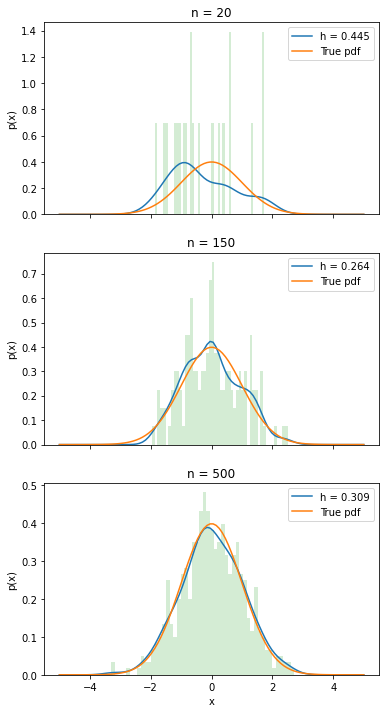

In [5]:
#1

n_samples = np.array([20,150,500])

fig, axs = plt.subplots(len(n_samples), sharex=True)
fig.set_size_inches(6,12)

for idx, n in enumerate(n_samples):
    x = npr.randn(n)
    logls = loocv_kernel_density(x, hs)
    best_h = hs[np.argmax(logls)]
    y = kernel_density(t, x, best_h)
    axs[idx].plot(t, y, label='h = %.3f'%best_h)
    y_gauss = K_gauss(t)
    axs[idx].plot(t, y_gauss, label='True pdf')
    axs[idx].hist(x, 50, density=True, alpha = 0.2)
    axs[idx].legend(loc='upper right')
    axs[idx].set(ylabel='p(x)')
    axs[idx].set_title('n = ' + str(n))

axs[-1].set(xlabel='x')
plt.show()

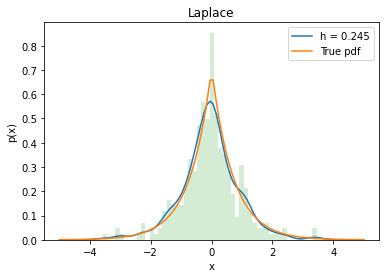

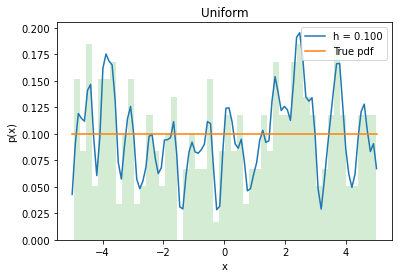

In [6]:
#2
from scipy.stats import laplace
n_samples = 300
x = npr.laplace(size=n_samples, scale=1/np.sqrt(2))
logls = loocv_kernel_density(x, hs)
myh = hs[np.argmax(logls)]
y = kernel_density(t, x, myh)
plt.plot(t, y, label='h = %.3f'%myh)
y_lap = laplace.pdf(t, scale=1./np.sqrt(2))
plt.plot(t, y_lap, label='True pdf')
plt.hist(x, 50, density=True, alpha = 0.2)
plt.legend(loc='upper right')
plt.title('Laplace')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()

x = npr.uniform(size=n_samples, low=-5., high=5.)
logls = loocv_kernel_density(x, hs)
myh = hs[np.argmax(logls)]
y = kernel_density(t, x, myh)
plt.plot(t, y, label='h = %.3f'%myh)
plt.plot(t, np.ones(len(t))/10, label='True pdf')
plt.hist(x, 50, density=True, alpha = 0.2)
plt.legend(loc='upper right')
plt.title('Uniform')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()

In [7]:
#3

def K_mvgauss(x):
    """Multivariate normal kernel."""
    d = x.shape[1]
    return (2*np.pi)**(-d/2)*np.exp(-0.5*np.sum(x**2, 1))

def mv_kernel_density(t, x, h):
    """Multivariate normal kernel density estimate."""
    d = x.shape[1]
    return np.mean(K_mvgauss((t - x)/h))/h**d

def mv_loocv_kernel_density(x, hs):
    """Multivariate kernel density estimation via leave-one-out cross-validation """
    logls = np.zeros(len(hs))
    for j in range(len(x)):
        train_x = np.delete(x, j, axis=0) # Remove the j-th point
        test_x = np.array([x[j]]) # Single test point
        for i in range(len(hs)):
            logls[i] += np.log(mv_kernel_density(test_x, train_x, hs[i]))
    # print('LOO log-probabilities:', logls)
    return hs[np.argmax(logls)]

ds = np.array([3,10,20])
hs = np.linspace(0.1, 1.0, 100)

for d in ds:
    x = npr.normal(size=[30, d])
    t0 = np.zeros((1, d))
    t1 = np.ones((1, d))
    myh = mv_loocv_kernel_density(x, hs)
    print('d =',d, '; h =', myh)
    print('True density and estimate at origin', K_mvgauss(t0),
                                                 mv_kernel_density(t0,x,myh))
    print('True density and estimate at (1,...,1)', K_mvgauss(t1),
                                                    mv_kernel_density(t1,x,myh))

d = 3 ; h = 0.6545454545454545
True density and estimate at origin [0.06349364] 0.04877982468717319
True density and estimate at (1,...,1) [0.01416735] 0.00948923199016193
d = 10 ; h = 0.9181818181818181
True density and estimate at origin [0.00010212] 4.262421439347109e-06
True density and estimate at (1,...,1) [6.8806307e-07] 4.123909246123286e-07
d = 20 ; h = 1.0
True density and estimate at origin [1.04280071e-08] 1.0566142555666988e-11
True density and estimate at (1,...,1) [4.73430788e-13] 1.375342870788436e-14


C:\Users\luigi\AppData\Local\Temp/ipykernel_18136/167749771.py:20: RuntimeWarning: divide by zero encountered in log
  logls[i] += np.log(mv_kernel_density(test_x, train_x, hs[i]))


### 4. Variants of cross-validation

Leave-one-out cross-validation can be computationally demanding when the number of samples is large. In this task you will test a few alternatives on the case of problem 2.

1. $k$-fold cross-validation: partition the data to $k$ disjoint blocks. Fit the density to $k-1$ blocks and compute the log-probability of the remaining block. Repeat $k$ times leaving each block for testing at the time. Implement $k$-fold cross-validation and test it with different values of $k$. (Note: this reduces to LOO-CV when $k=n$ for $n$ samples.)
2. Monte Carlo cross-validation: randomly partition the data to a training set for fitting the density and a test set for evaluating the probability, with the desired split between training and test data. A split of 80% training / 20% testing is typical, but this can vary depending on data characteristics. Repeat until the desired level of accuracy has been reached. Implement Monte Carlo cross-validation and test it with different parameters.
3. Which method seems most useful in getting accurate results quickly?

*Hint*: One way to generate and access the $k$ blocks for $k$-fold cross-validation in Python is based on boolean index vectors. Assuming we have $N$ samples, the $i$th out of $k$ index vectors can be generated using
``` {python}
    testI = np.zeros(N, np.bool)
    testI[((i*N)//k):(((i+1)*N)//k)] = True
    trainI = ~testI
```

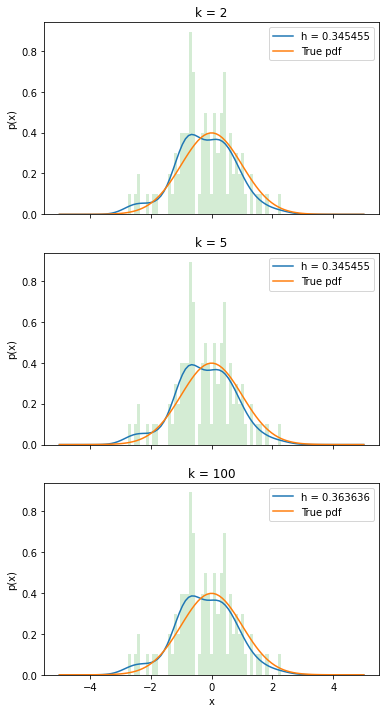

In [8]:
#1

def k_foldcv(x, k, hs):
    """K-fold cross-validation."""
    N = len(x)
    I = npr.permutation(N)
    logls = np.zeros(len(hs))
    for j in range(k):
        testI = np.zeros(N, bool)
        testI[((j*N)//k):(((j+1)*N)//k)] = True
        trainI = ~testI
        for i in range(len(hs)):
            logls[i] += np.sum(np.log(kernel_density(x[I[testI]], x[I[trainI]], hs[i])))
    return (hs, logls)

x = npr.randn(100)

hs = np.linspace(0.1, 1.0, 100)
k_folds = [2, 5, 100]

fig, axs = plt.subplots(len(k_folds), sharex=True)
fig.set_size_inches(6,12)

for idx, k in enumerate(k_folds):
    hs, logls = k_foldcv(x, k, hs)
    myh = hs[np.argmax(logls)]
    y = kernel_density(t, x, myh)
    axs[idx].plot(t, y, label='h = %f'%myh)
    y_gauss = K_gauss(t)
    axs[idx].plot(t, y_gauss, label='True pdf')
    axs[idx].hist(x, 50, density=True, alpha = 0.2)
    axs[idx].legend(loc='upper right')
    axs[idx].set(ylabel='p(x)')
    axs[idx].set_title('k = ' + str(k))

axs[-1].set(xlabel='x')
plt.show()


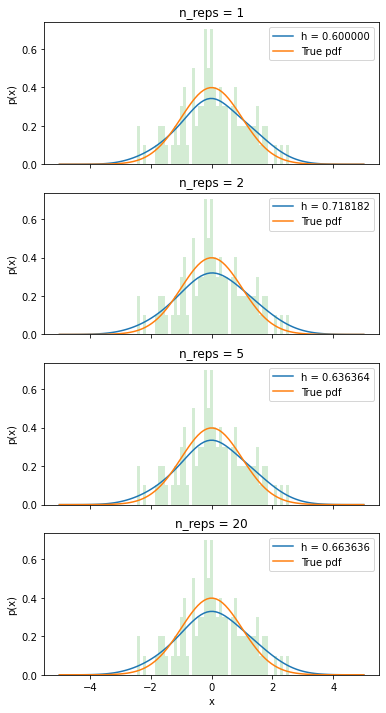

In [9]:
#2

def mc_cv(x, train_frac, n_reps, hs):
    """Monte Carlo cross-validation."""
    N = len(x)
    I = np.zeros((n_reps,N), dtype=int)
    for i in range(n_reps):        
        I[i] = npr.permutation(N)
    hs = np.linspace(0.1, 1.0, 100)
    logls = np.zeros(len(hs))
    
    testI = np.zeros(N, bool)
    testI[0:int(train_frac*N)] = True
    trainI = ~testI
    
    for j in range(n_reps):
        test_x = x[I[j][testI]]
        train_x = x[I[j][trainI]]        
        for i in range(len(hs)):
            logls[i] += np.sum(np.log(kernel_density(test_x, train_x, hs[i])))
    return (hs, logls)

x = npr.randn(100)
train_frac = 0.8

hs = np.linspace(0.1, 1.0, 100)
n_reps = [1, 2, 5, 20]

fig, axs = plt.subplots(len(n_reps), sharex=True)
fig.set_size_inches(6,12)

for idx, n in enumerate(n_reps):
    hs, logls = mc_cv(x, train_frac, n, hs)
    myh = hs[np.argmax(logls)]
    y = kernel_density(t, x, myh)
    axs[idx].plot(t, y, label='h = %f'%myh)
    y_gauss = K_gauss(t)
    axs[idx].plot(t, y_gauss, label='True pdf')
    axs[idx].hist(x, 50, density=True, alpha = 0.2)
    axs[idx].legend(loc='upper right')
    axs[idx].set(ylabel='p(x)')
    axs[idx].set_title('n_reps = ' + str(n))

axs[-1].set(xlabel='x')
plt.show()
